<div style="background-color:#009440; padding: 0px; background-size:cover; background-opacity:50%; border-radius:5px; height:300px">
    <div style="margin: 5px; padding: 10px;">
    <h1 style="color:#00000">Geophysical Data Acquisition and Analysis</h1>
    <h5 style="color:#C0C0C0">LMU, summer 2016</h5>
    <h4 style="color:rgba(0,0,0,0.6)">Stefanie Donner, Céline Hadziioannou, Ceri Nunn</h4>
    </div>
    <div style="float:right; margin: 20px; padding: 20px; background:rgba(255,255,255,0.7); width: 70%; height: 100px">
        <div style="position:relative; top:40%; transform: translateY(-50%)">
        <div style="font-size: x-large; font-weight:900; color:rgba(0,0,0,0.8); line-height:100%">P2.4 - Final exam report</div>
        </div>
    </div>
   
</div>

## Rules + deadline

In the following you find five exercises plus some basic code. Adapt the code as needed to answer the questions and provide your answers in separate markdown cells below the exercise. Please, do not forget to label axes, lines, titles, etc in your plots.  
Make sure that your answers are as elaborate and detailed as necessary to make your answer clear. However, concentrate on the essentials. 

In case you refer to literature/sources outside the course material, do not forget to acknowledge or cite them properly. You are also allowed to include images from outside the notebook if that may help you to explain. In that case, do not forget to provide us with the image files then. This is how you import figures in markdown: 

`<img style="float: left; height: 350px; padding: 10px" src="DATA/figure.jpg"/>`

For help with coding, please, consult the official [Python](http://docs.python.org/) and [ObsPy](http://docs.obspy.org) documentation. For help in formating the markdown cells, you can find help e.g. at the webpage of [wikipedia](https://en.wikipedia.org/wiki/Markdown) or on the [cheat sheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet). In case of severe problems, please contact us in time.

Submit your final notebook via mail to Stefanie Donner (donner@geophysik.uni-muenchen.de) at the latest 

### August 5th, 23:55 !!!

Notebooks received after that time will not be considered.

*Please, do not forget to execute Cell 0 first!*

<br>
<br>

In [4]:
# Cell 0: Preparation for programming
%pylab inline
from __future__ import print_function
from scipy import interpolate, signal
from time import *
from obspy import *
from obspy.core import read, UTCDateTime
from obspy.clients.fdsn import Client
from obspy.signal.cross_correlation import xcorr_pick_correction
import numpy as np
import matplotlib.pylab as plt
import os
import glob
import wave
import struct
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 10
plt.rcParams['lines.linewidth'] = 1

Populating the interactive namespace from numpy and matplotlib


______________

## Exercise 1

In this exercise you will work on broadband data from the Mw8.2 Chile earthquake from 1st of April 2014 at 23:46:47 UTC recorded at the black forest station in SW Germany (BFO). The goal of this exercise is to show your understanding of the principal basics in signal processing. Answer the following questions and perform the necessary steps in the corresponding code cells.

a) In cell 1a you fetch the waveforms via the FDSN client of IRIS and remove the instrument characteristic of the data (no further coding necessary here). Explain what "removing the instrument response" means and why it is necessary. Which mathematical method do you connect with this step? What is to consider during instrument response removal? A hint is given by the options used for removing the instrument response. Comment on all of them.

b) Now that you have downloaded the data and removed the instrument response, which further steps do you need to perform for pre-processing? Assume that for your scientific task the highest frequency you want to analyse is 5Hz. Describe the general pre-processing chain and point out the possible pitfalls and how to avoid them. Among others, some steps are high-pass filtering and demean as well as detrend the trace. Why do you do so?

c) Bonus _(Optional, for extra points)_: Try to plot the ray paths for this special earthquake receiver pair. Identify which phases should be theoretically visible in the seismogram. Try to identify them. 

3 Trace(s) in Stream:
II.BFO.00.BHE | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples
II.BFO.00.BHN | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples
II.BFO.00.BHZ | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples


II.BFO.00.BHZ | 2014-04-01T23:30:00.019500Z - 2014-04-02T02:29:59.969500Z | 20.0 Hz, 216000 samples

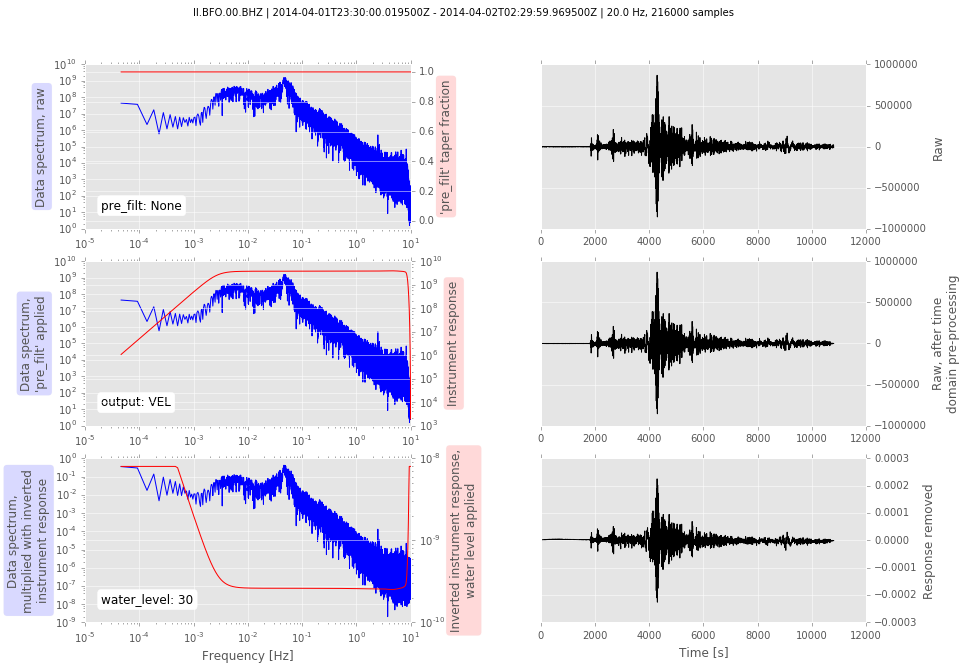

In [23]:
# Cell 1a : getting the waveforms

client = Client("IRIS")
t = UTCDateTime("2014-04-01T23:30:0.0")

st = client.get_waveforms("II", "BFO", "*", "BH?", t, t+(180*60), attach_response=True)
print(st)
st[0].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   plot=False)
st[1].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   plot=False)
st[2].remove_response(output="VEL", pre_filt=None, water_level=30, zero_mean=True, taper=True, taper_fraction=0.05, 
                   plot=True)

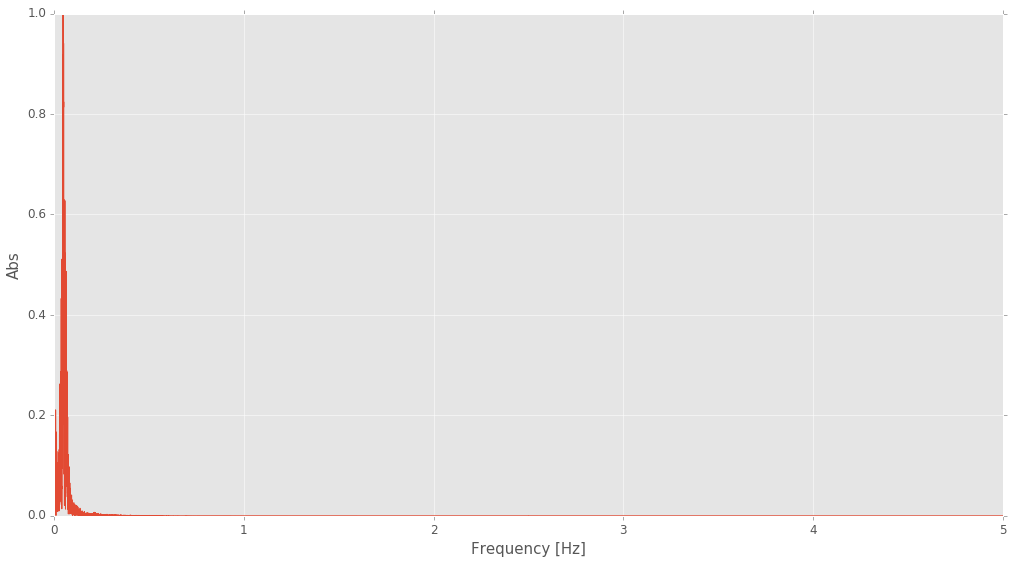

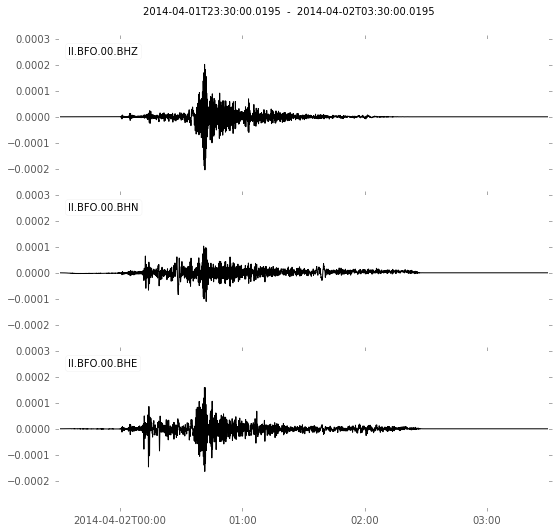

In [32]:
# Cell 1b: pre-processing the data

# take a copy of the stream to avoid overwriting the original data
bfo = st.copy()
tr = bfo[2]

# pre-processing
df = tr.stats.sampling_rate
npts = tr.stats.npts
tr.data = tr.data.astype('float64') # convert to double
tr.data = detrend(tr.data, 'linear') # de-trend

# apply windowing function to ensure the real waveform data- 
# starts and ends at zero
tr.data *= np.hanning(npts) # window

# define the total length of the record 
n = int(len(tr.data)*1.0)

# do the fourier transform
fdat = np.fft.rfft(tr.data, n=n)

# take the first 5 Hz only
N = len(fdat) * 0.5
N = int(N)
freq = np.linspace(0, df/2, len(fdat))
freq = freq[1:N+1] # zero frequency is offset
fdat = fdat[1:N+1]
fdat /= abs(fdat).max() # normalize to 1

# plot the results
from matplotlib import rcParams
rcParams["figure.subplot.hspace"] = (0.4)
rcParams["figure.figsize"] = (17, 9)
rcParams["axes.labelsize"] = (15)
rcParams["axes.titlesize"] = (20)
rcParams["font.size"] = (12)

plt.figure()
plt.plot(freq, abs(fdat))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Abs')
plt.show()

# 1. Filter the analog record to avoid aliasing
# 2. Digitise such that the Nyquist frequency lies above the highest
#    frequency in the original data.
# 3. Window to appropriate length.
# 4. Detrend (i.e. remove the best-fitting line)
# 5. Taper to smooth the ends of the record to avoid Gibbs
#    phenomenon.
# 6. Pad with zeros to smooth the spectrum and/or to lengthen the
#    record to avoid spectral leakage.

# in time domain we have:
trc = bfo
bfo.detrend() # detrend
bfo.taper(max_percentage = 0.05) # apply taper
bfo.filter("lowpass", freq = 5.0) # apply lowpass 5Hz
bfo.trim(t,t+(240*60),pad = True, fill_value = 0) # trim for zero padding
bfo.plot()

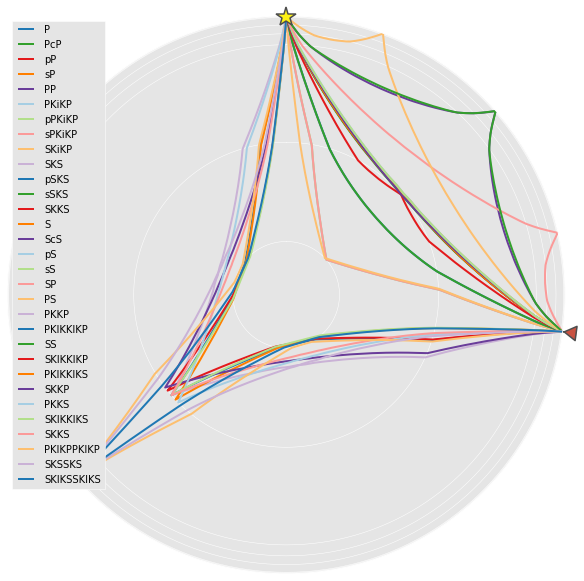

In [235]:
# Cell 1c - part 1: plot of ray pathes for this EQ-receiver pair

from obspy.taup import TauPyModel

# use model IASP91
model = TauPyModel(model='iasp91')

# plot all of ray pathes for this Chile EQ-receiver BFO
# we can get information about earthquake depth and distance between EQ and BFO
# from IRIS Welber 3 webpage: "http://ds.iris.edu/wilber3/find_event"
arrivals = model.get_ray_paths(source_depth_in_km=25, distance_in_degree=97.60)
arrivals.plot(plot_type='spherical', legend=True, label_arrivals=False)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: ObsPyDeprecationWarning: The travelTimePlot() function is deprecated. Please use the obspy.taup.TauPyModel class directly.


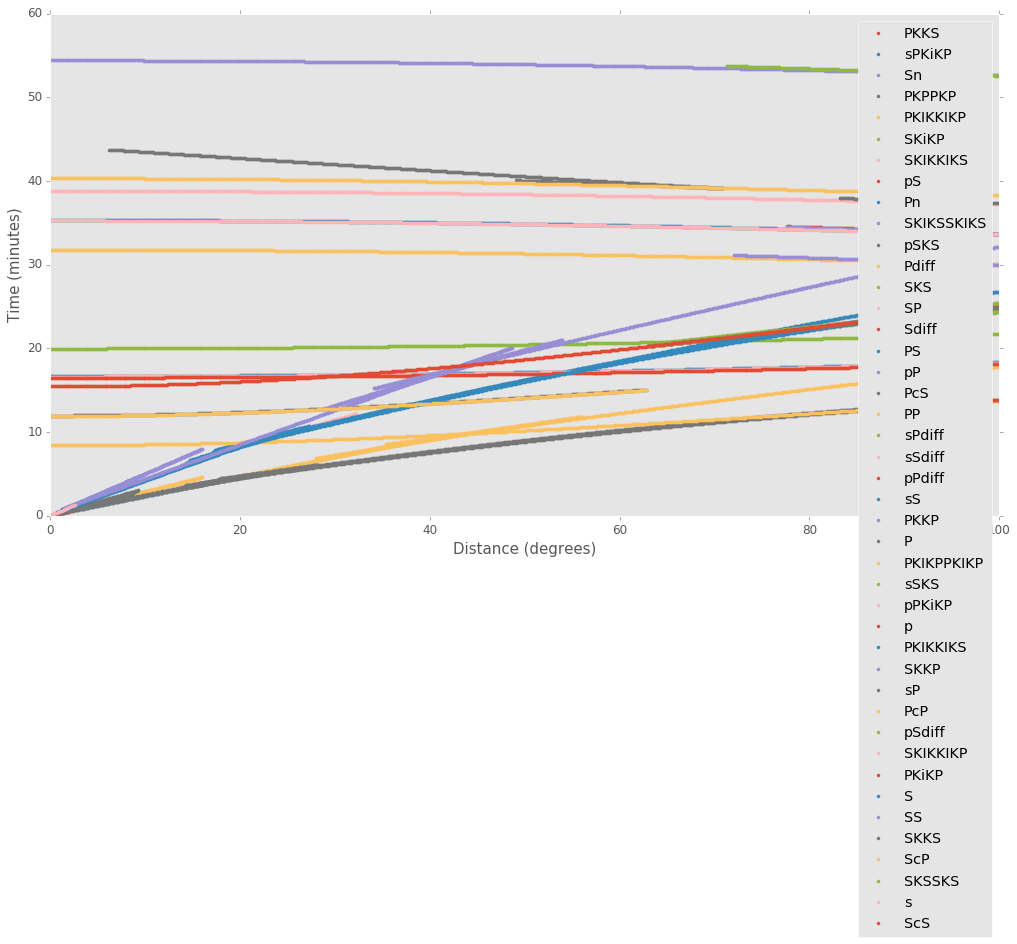

In [177]:
# Cell 1c - part 2: plot seismogram with theoretical travel times

# loading the necessary package as a hint ...
from matplotlib.pyplot import cm
from obspy.taup.taup import travelTimePlot

travelTimePlot(min_degree=0, max_degree=100, depth=25, model='iasp91')

### Answer to exercise 1

a)
"Removing the instrument response" means restitution. It is necessary because our seismometers act as a filter on the recorded data i.e. distortion and scaling of the data and therefore must be removed before the actual ground motion units can be accurately represented. "Filter-effect" needs to be corrected by restitution (removing instrument response). Mathematical method that connect with this step is deconvolution. Deconvolution is an algorithm-based process used to reverse the effects of convolution on recorded data. Deconvolution is usually performed by computing the Fourier Transform of the recorded signal and the transfer function, and we apply deconvolution in the Frequency domain. During instrument response removal, we consider noise that has entered our recorded signal. The solution for the presence of noise is by using water level method which is basically adding white noise. It is necessary to put it into account to keep the input signal from blown up effect at zero or near zero event.

Taken from obspy (link below):
Note that there are two ways to prevent over amplification while convolving the inverted instrument spectrum: One possibility is to specify a water level which represents a clipping of the inverse spectrum and limits amplification to a certain maximum cut-off value (water_level in dB). The other possibility is to taper the waveform data in the frequency domain prior to multiplying with the inverse spectrum, i.e. perform a pre-filtering in the frequency domain (specifying the four corner frequencies of the frequency taper as a tuple inpre_filt).

1. output (str)
Output units. One of:
"DISP"
displacement, output unit is meters
"VEL"
velocity, output unit is meters/second
"ACC"
acceleration, output unit is meters/second**2
2. water_level (float) : Water level for deconvolution.
3. pre_filt (list or tuple of four float) : Apply a bandpass filter in frequency domain to the data before deconvolution. The list or tuple defines the four corner frequencies (f1, f2, f3, f4) of a cosine taper which is one betweenf2 and f3 and tapers to zero for f1 < f < f2 and f3 < f < f4.
4. zero_mean (bool) : If True, the mean of the waveform data is subtracted in time domain prior to deconvolution.
5. taper (bool) : If True, a cosine taper is applied to the waveform data in time domain prior to deconvolution.
6. taper_fraction (float) : Taper fraction of cosine taper to use.
7. plot (bool or str) : If True, brings up a plot that illustrates how the data are processed in the frequency domain in three steps. First by pre_filt frequency domain tapering, then by inverting the instrument response spectrum with or without water_level and finally showing data with inverted instrument response multiplied on it in frequency domain. It also shows the comparison of raw/corrected data in time domain. If a str is provided then the plot is saved to file (filename must have a valid image suffix recognizable by matplotlib e.g. ‘.png’).
taken from “http://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.remove_response.html#obspy.core.trace.Trace.remove_response”

b) 
The general pre-processing chain:
1. Filter the analog record to avoid aliasing
2. Digitise such that the Nyquist frequency lies above the highest frequency in the original data.
3. Window to appropriate length.
4. Detrend (i.e. remove the best-fitting line)
5. Taper to smooth the ends of the record to avoid Gibbs phenomenon.
6. Pad with zeros to smooth the spectrum and/or to lengthen the record to avoid spectral leakage.

c)
In the presence of enough energy, theoretically we will have P and S ray pathes clearly, other ray pathes as shown on the picture above on cell 1c part 1 while its travel times plot on cell 1c part 2.


_____________
## Exercise 2 : Marienplatz Glockenspiel - spectral analysis

In the very top of the tower of the New Town Hall (Rathaus) on Marienplatz, there are 43 bells, which chime different tunes daily at 11am and 12am. The tunes accompany a spectacle of figurines that move and illustrate local stories.  
In this exercise, we will analyze a recording of the Glockenspiel bells. 

You can read more about the Glockenspiel here: https://en.wikipedia.org/wiki/Rathaus-Glockenspiel

You can listen to the first tune of the Glockenspiel recording by playing `data/Glockenspiel_Marienplatz_track1.wav`  


---

<img style="float: left; height: 350px; padding: 10px" src="data/rathaus_munchen.jpg"  />
<img style="float: right; height: 350px; padding: 10px" src="data/glockenspiel_inside.jpg"  />


###### Acknowledgement
_photo Rathaus (left): _ https://commons.wikimedia.org/wiki/File:Altes_Rathaus_und_Mariens%C3%A4ule_in_M%C3%BCnchen.jpg  
_photo inside Glockenspiel (right): Thies Heidecke_  
_We are grateful to the personnell at the Rathaus for providing access to the Glockenspiel tower._  
_We thank Thies Heidecke for his help with the recording. _

In [13]:
# Cell 2a-1 - Read in the .wav file

# read in the file 
dataDir = './data/'
fileName = 'Glockenspiel_Marienplatz_track1.wav'
# if your computer cannot handle the complete tune, use this file instead (only first 15 seconds)
#fileName = 'Glockenspiel_Marienplatz_track1_short.wav'

stream = wave.open(dataDir + fileName,'r')

# get the details about the .wav file
num_channels = stream.getnchannels()
frame_rate = stream.getframerate()     # sampling rate
sample_width = stream.getsampwidth()   
num_frames = stream.getnframes()      # number of points
total_samples = num_frames * num_channels
endtime = float(total_samples) / float(frame_rate)

# read the byte data
raw_data = stream.readframes( num_frames )
stream.close()

# check the type of audio track
if sample_width == 1: 
    fmt = "%iB" % total_samples # read unsigned chars
elif sample_width == 2:
    fmt = "%ih" % total_samples # read signed 2 byte shorts
else:
    raise ValueError("Only supports 8 and 16 bit audio formats.")

# unpack the byte data to integers
integer_data = struct.unpack(fmt, raw_data)

# Keep memory tidy
del raw_data

# set up the channel
channels = [ [] for time in range(num_channels) ]

# read the integers to channels
for index, value in enumerate(integer_data):
    bucket = index % num_channels    
    channels[bucket].append(value)
    
# signal and timeseries arrays:
gsignal = channels[0]
time = np.linspace(0,endtime,total_samples)  # in seconds

print('Number of samples in the signal:', len(gsignal)) 

Number of samples in the signal: 3969000


1 Trace(s) in Stream:
... | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:01:29.999977Z | 44100.0 Hz, 3969000 samples


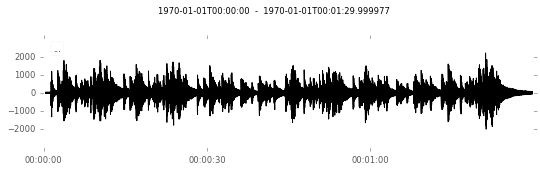

In [14]:
# Cell 2a-2 - read .wav into obspy Stream object

st = read(dataDir + fileName)
print(st)
st.plot()

# just the signal array and time vector
gsignal_st = st[0].data
time_st = st[0].times()

In the previous two cells, the glockenspiel tune has been read in two different ways:

+ `gsignal` is a numpy array with the signal values. Associated time vector is 'time'; sampling rate is in the variables 'frame_rate'
+ `st` is an obspy stream object with the same glockenspiel tune. You can manipulate it in the same way as other stream objects in previous practicals. 

Both contain the same signal, so you can use whichever one is easiest in the following exercise. 

### Questions - part 1

**Note:** if the signal is too large for your computer to handle, use the alternative, shorter signal which contains only the first 15 seconds of the tune. See Cell 2a, where the filename is defined. 

Create several subplots: plot the signal on top, and below that create two subplots: in the first, plot the spectrogram using a window length of 256 samples. 
In the second, plot the spectrogram with a window length of 4096 samples. In both, use an overlap of 50. 

a) Explain what a spectrogram (in general) represents. Through which mathematical operation is the y-axis (frequency axis) created? What controls the value of the upper limit of the y-axis?

b) Compare the spectrograms with `NFFT=256` and `NFFT=4096`. What difference between the two do you notice? Think in terms of time and frequency resolution. Explain why this happens.  
Remember you can zoom in to specific parts of the signal by manipulating the plot limits 
(`plt.xlim((value1, value2))` or `plt.ylim((value1, value2))`) 

c) On both spectrograms, zoom in to frequency around 6780 Hz using `plt.ylim((value1, value2))` . This frequency corresponds to one of the bells. Isolate the signal of this bell as much as you can using a filter.  
Go to Cell 2c. In a new plot, plot the original (unfiltered) signal and the filtered signal on top of each other with different colors. How often does the 6780Hz bell ring in the first 10 seconds of the song? (You may want to trim the signal to the first 10 seconds first). 

d) If you plot a spectrogram of the filtered signal, you will see that the energy of the signal outside your filter band is not exactly zero. What is this effect called?  
Explain how you could achieve a narrower filter (you do not need to execute it for this signal, just describe). What kind of tradeoff will you encounter as you use a narrower filter window? 



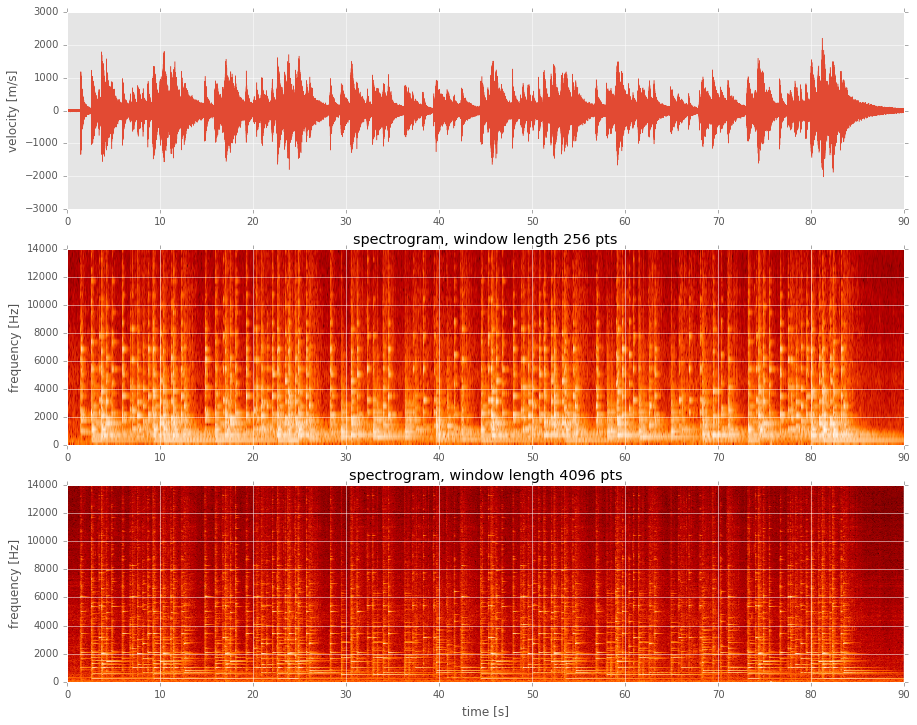

In [15]:
# Cell 2b - compare spectograms
# Plotting the spectrograms

NFFT = 256  # the length of the spectrogram window in sample points, version 1
NFFT2 = 4096  # length of spectrogram window, version 2 
tr = st[0]
Fs = int(tr.stats.sampling_rate)  # the sampling frequency
noverlap = 50      # number of sample points that the sliding window overlaps, must be less than NFFT

plot_freq_min = 0       # the lower frequency bound for the plot, in Hz
plot_freq_max = 14000     # the upper frequency bound for the plot, in Hz

# x axis limits in the plot, in seconds
xstart = 0
xend = 90

# note: if this is taking too long, or ends in a "MemoryError", try using a longer window length "wlen" (in seconds)
# looking at a shorter time window can also help (try adapting t1 and t2 in cell number XXX. But watch out, 
# this will shorten the signal permanently until you rerun all cells)

tr = st[0].copy()

plt.figure(figsize=(15,12))
ax1 = plt.subplot(311)
plt.plot(tr.times(), tr.data, linewidth=0.5)
plt.ylabel('velocity [m/s]')
plt.subplot(312, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT, Fs=tr.stats.sampling_rate, noverlap=noverlap,
                                cmap=cm.gist_heat)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
plt.ylabel('frequency [Hz]')
plt.ylim((plot_freq_min, plot_freq_max))
plt.subplot(313, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT2)
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT2, Fs=tr.stats.sampling_rate, noverlap=noverlap,
                                cmap=cm.gist_heat)
plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((xstart, xend))

plt.show()

### Answer to exercise 2 - part 1/1

a) Graph of the energy content of a signal expressed as function of frequency and time. Graph of a signal in which the vertical axis is frequency, the horizontal axis is time, and amplitude is shown on a colour-scale.
taken from “http://www.phon.ucl.ac.uk/courses/spsci/acoustics/week1-10.pdf”

The spectrogram of a signal can be estimated by computing the squared magnitude of the short-time Fourier transform of the signal.
taken from "https://en.wikipedia.org/wiki/Spectrogram"

The upper limit of the y-axis is controlled by uncertainty principle, i.e. this is trade-off between the precision of the representation in the time- and frequency-domain.

b)
Based on the Fourier analysis window, we observe various levels of frequency and time resolution. 
A long window (4096 pts) resolves frequency at the expense of time—the result is a narrow band spectrogram, which reveals individual harmonics (component frequencies), but smears together adjacent 'moments'. 
If a short analysis window is used (256 pts), adjacent harmonics are smeared together, but with better time resolution. The result is a wide band spectrogram in which individual pitch periods appear as vertical lines. Generally, wide band spectrograms are used in spectrogram reading because they give us more information about what's going on in the vocal tract.


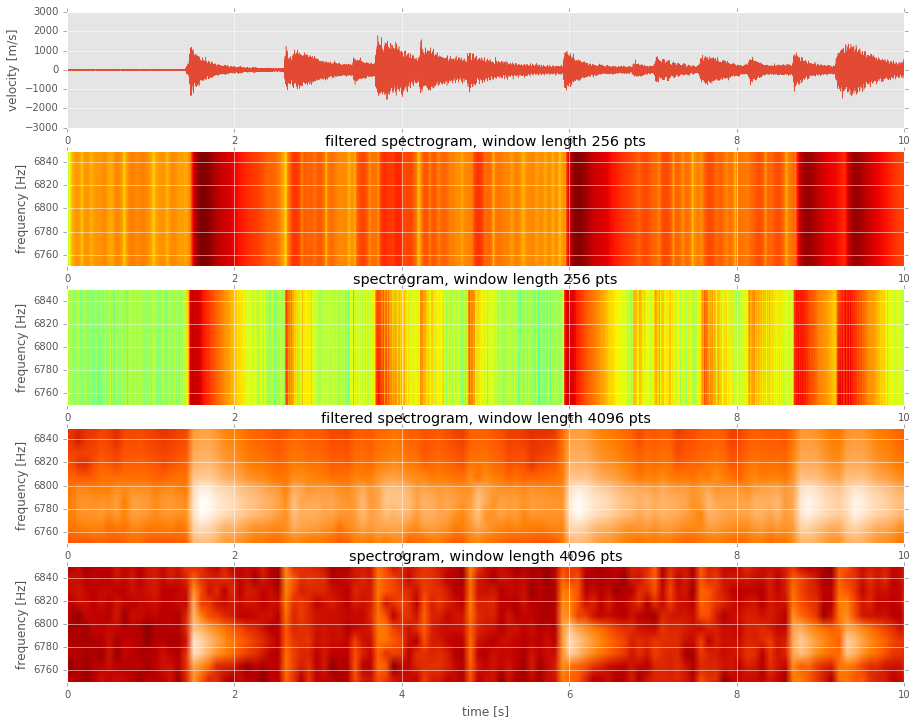

In [16]:
# Cell 2c - isolate single bell

from obspy.signal.filter import bandpass

f_bell = 6780
stb = st.copy()

stb_bandpass=stb.filter("bandpass", freqmin = 6775, freqmax=6785)

# Plotting the spectrograms

NFFT = 256  # the length of the spectrogram window in sample points, version 1
NFFT2 = 4096  # length of spectrogram window, version 2 
tr = st[0]
tr_filtered = stb_bandpass[0]
Fs = int(tr.stats.sampling_rate)  # the sampling frequency
noverlap = 50      # number of sample points that the sliding window overlaps, must be less than NFFT

plot_freq_min = 6750       # the lower frequency bound for the plot, in Hz
plot_freq_max = 6850     # the upper frequency bound for the plot, in Hz

# x axis limits in the plot, in seconds
xstart = 0
xend = 10

# note: if this is taking too long, or ends in a "MemoryError", try using a longer window length "wlen" (in seconds)
# looking at a shorter time window can also help (try adapting t1 and t2 in cell number XXX. But watch out, 
# this will shorten the signal permanently until you rerun all cells)

tr = st[0].copy()

plt.figure(figsize=(15,12))
ax1 = plt.subplot(511)
plt.plot(tr.times(), tr.data, linewidth=0.5)
plt.ylabel('velocity [m/s]')


plt.subplot(512, sharex=ax1)
plt.title('filtered spectrogram, window length %s pts' % NFFT)
Pxx, freqs, bins, im = plt.specgram(tr_filtered.data, NFFT=NFFT, Fs=tr.stats.sampling_rate, noverlap=noverlap,
                                cmap=cm.jet)
plt.ylabel('frequency [Hz]')
plt.ylim((plot_freq_min, plot_freq_max))


plt.subplot(513, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT, Fs=tr.stats.sampling_rate, noverlap=noverlap,
                                cmap=cm.jet)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
plt.ylabel('frequency [Hz]')
plt.ylim((plot_freq_min, plot_freq_max))

plt.subplot(514, sharex=ax1)
plt.title('filtered spectrogram, window length %s pts' % NFFT2)
Pxx, freqs, bins, im = plt.specgram(tr_filtered.data, NFFT=NFFT2, Fs=tr.stats.sampling_rate, noverlap=noverlap,
                                cmap=cm.gist_heat)
plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')


plt.subplot(515, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT2)
Pxx, freqs, bins, im = plt.specgram(tr.data, NFFT=NFFT2, Fs=tr.stats.sampling_rate, noverlap=noverlap,
                                cmap=cm.gist_heat)
plt.ylim((plot_freq_min, plot_freq_max))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.xlim((xstart, xend))

plt.show()

### Answer to exercise 2 - part 1/2

a) The 6780Hz bell ring 4 times in the first 10 seconds of the song. Those are events in 1.5 s, 6 s, 8.5 s and 9.2 s (approximately).

b) The energy of the signal outside our filter band is not exactly zero. This effect is called ringing or multiple effect.
We could achieve a narrower filter by reducing the window length.
We will encounter tradeoff between time and frequency as we use a narrower filter window.
If a short analysis window is used (i.e. 256 pts), adjacent harmonics are smeared together, but with better time resolution. The result is a wide band spectrogram in which individual pitch periods appear as vertical lines.

### Questions - part 2

In the following Cell 2d, we consider part of the spectral content of a single bell chime. The spectrum is calculated for several different lengths of time window:  
1. the complete bell chime (approx. 0.8 seconds)
2. a short time window (500 samples)
3. a longer time window (3000 samples)
4. the longer time window, with the rest of the signal set to zero (so 3000 samples + zero padding to complete signal length) (**Note:** in the first plot, the blue signal is offset downwards by 500 points. This is just to make the difference between green and blue line more visible. ) 

Explain the difference between the spectra obtained with the different time window lengths. 
In particular, consider why the peak around f=3750Hz does not show up when using the shortest time window (red line). Why is the blue spectrum smoother than the green one? 



1 Trace(s) in Stream:
... | 1970-01-01T00:00:09.100000Z - 1970-01-01T00:00:09.900000Z | 44100.0 Hz, 35281 samples


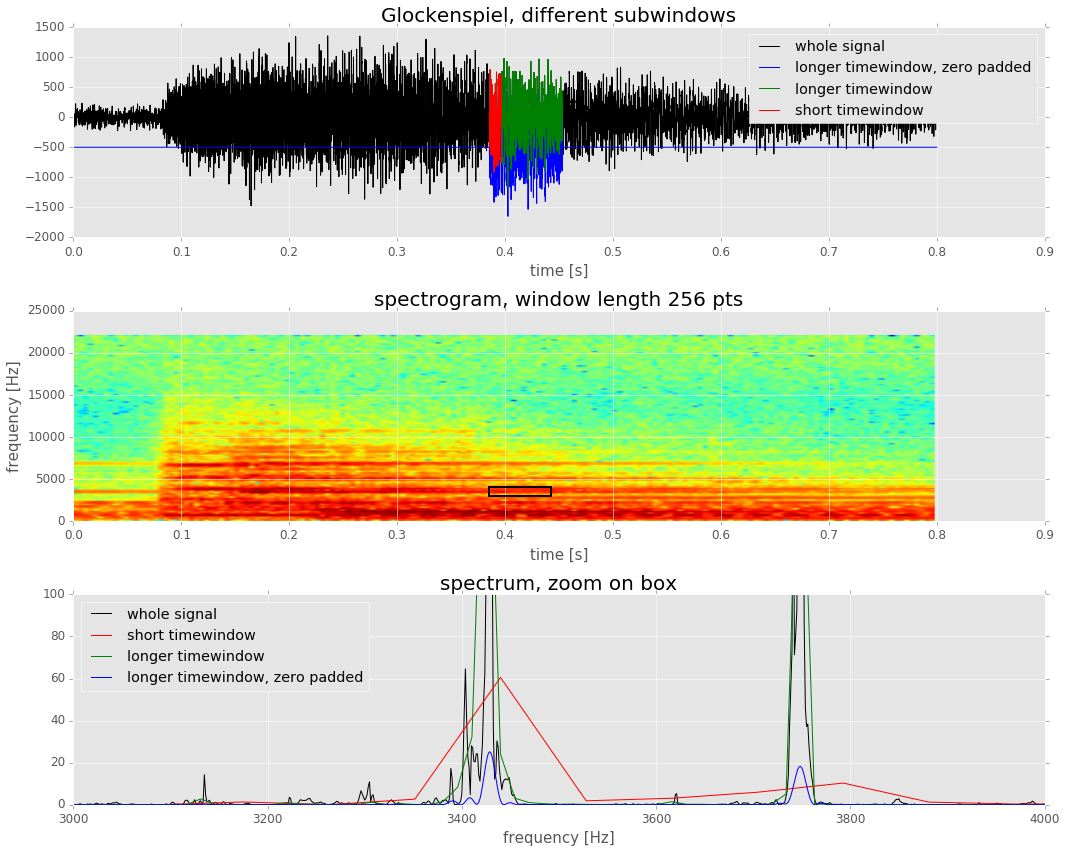

In [185]:
# Cell 2d - single bell chime

NFFT = 256

# time limits to trim signal to, in seconds 
ts1 = st[0].stats.starttime + 9.1
ts2 = ts1 + 0.8

# subwindow lengths, in samples
lwin1 = 500
lwin2 = 3000

# time limits for subwindow in signal, in samples
lim1 = 17000
lim2 = lim1 + lwin1
lim3 = lim1 + lwin2

stsh = st.copy()
stsh.trim(ts1, ts2)
print(stsh)

stz = st.copy()
stz.trim(ts1, ts2)
# set signal outside subwindow to zero
stz[0].data[0:lim1] = 0
stz[0].data[lim3:] = 0

# calculate spectrum for different window lengths:
# whole signal (black)
f, Pxx_den = signal.periodogram(stsh[0].data, stsh[0].stats.sampling_rate)
# short timew window (red)
f2, Pxx_den2 = signal.periodogram(stsh[0].data[lim1:lim2], stsh[0].stats.sampling_rate)
# longer time window (green)
f3, Pxx_den3 = signal.periodogram(stz[0].data[lim1:lim3], stz[0].stats.sampling_rate)
# longer time window, with zero padding around it (blue)
f4, Pxx_den4 = signal.periodogram(stz[0].data, stz[0].stats.sampling_rate)

# plot signal, spectrogram and spectrum (zoomed in to 2 peaks, as indicated by black box in spectrogram)
plt.figure(figsize=(15,12))

# time series
ax1 = plt.subplot(311)
plt.plot(stsh[0].times(), stsh[0].data, 'k', label='whole signal')
plt.plot(stz[0].times(), stz[0].data - 500, 'b', label='longer timewindow, zero padded')
plt.plot(stz[0].times()[lim1:lim3], stz[0].data[lim1:lim3], 'g', label='longer timewindow')
plt.plot(stsh[0].times()[lim1:lim2], stsh[0].data[lim1:lim2], 'r', label='short timewindow')
plt.legend()
plt.xlabel('time [s]')
plt.title('Glockenspiel, different subwindows')

plt.subplot(312, sharex=ax1)
plt.title('spectrogram, window length %s pts' % NFFT)
# Pxx is the segments x freqs array of instantaneous power, freqs is
# the frequency vector, bins are the centers of the time bins in which
# the power is computed, and im is the matplotlib.image.AxesImage instance
Pxx, freqs, bins, im = plt.specgram(stsh[0].data, NFFT=NFFT, Fs=frame_rate, noverlap=noverlap,
                                cmap=cm.jet,sides='onesided')
#draw box
plt.plot((lim1/frame_rate, (lim2+2000)/frame_rate), (3000, 3000), 'k-', lw=2)
plt.plot((lim1/frame_rate, (lim2+2000)/frame_rate), (4000, 4000), 'k-', lw=2)
plt.plot((lim1/frame_rate, lim1/frame_rate), (3000, 4000), 'k-', lw=2)
plt.plot(((lim2+2000)/frame_rate, (lim2+2000)/frame_rate), (3000, 4000), 'k-', lw=2)

#plt.ylim((0,5000))
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')

# show spectra calculated with different timewindows
plt.subplot(313)
plt.plot(f, Pxx_den, 'k', label='whole signal')
plt.plot(f2, Pxx_den2, 'r', label='short timewindow 500 samples')
plt.plot(f3, Pxx_den3, 'g', label='longer timewindow 3000 samples')
plt.plot(f4, Pxx_den4, 'b', label='longer timewindow, zero padded')
plt.legend(loc='upper left')
plt.xlabel('frequency [Hz]')
plt.title("spectrum, zoom on box")
plt.xlim((3000,4000))
plt.ylim((0,100))
# prevent subplots overlapping
plt.tight_layout() 
plt.show()

### Answer to exercise 2 - part 2

In short time window allows us to identify a precise time at which the signals change but the precise frequencies are difficult to identify. At the other end of the scale, in long time window allows the frequencies to be precisely seen but the time between frequency changes is blurred. This is due to the uncertainty principle, we can either have high precision of the frequency or high precision of the time but not in both, they are proportional in inverse way.

- In short time window (red line):
we have low frequency resolution, however we have high time resolution, In the red line we can not identify a sharp peak at the desired frequency of 3750Hz but rather get low amplitude noise level between 3500 and 3900 Hz due to adjacent harmonics are smeared together.

- In long time windows (green line & blue line):
We can observe sharp peaks at longer time windows (green line). We have good frequency resolution but low time resolution, this can be seen at the green line where 2 frequency peaks event within ranges 3380-3480 Hz and 3750-3770 Hz. 
However, we can not identify the contribution of each frequencies in this range. The solution is shown by the blue line is with zero padding. The blue line has higher frequency resolution. We can observe main events from blue line i.e. on first peak event is recognized from contribution of only few frequencies, compared to the green line. Note that the amplitude of these peak event is smaller than the unpadded event. The blue line is smoother than the green line due to more points.

_______________________

## Exercise 3

This question is about convolution of signals. You are provided with two signals. 

a) What is a convolution? Convolution is closely connected to a special kind of system. Which one? Describe the connection. <br> 
Using [signal.convolve](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html) convolve the two signals in Cell 3a. Set the mode='same'. Explain the meaning of the mode parameter. <br>
Plot the original signals and the convolved signal. Be careful to plot the entire signal on both the x and y axes. Include labels.  

b) In cell 3b, replace one of signals with a new signal that has a different shape. Convolve the signals and plot them again. Are convolutions commutative? 

c) In cell 3c, convolve the signals win and sig in the reverse order, continuing to use mode='same'. Replot. <br>
Are the results the same or different from cell 2a? Explain this result. Explain any inconsistencies.

d) Bonus _(optional for extra points)_: Amend the signals so that convolving them in the reverse order gives the same result as convolving them in original order. 

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


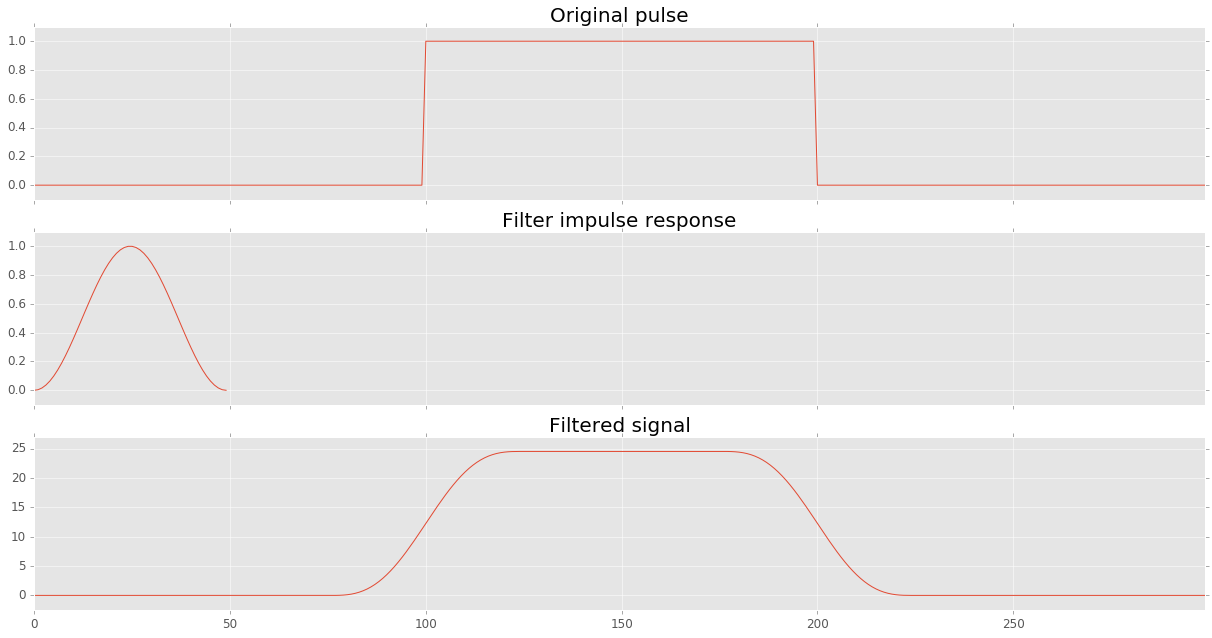

In [196]:
#Cell 3a - convolving two signals + plotting

# make a box car function
sig = np.repeat([0., 1., 0.], 100)

# make a Hann window 
win = signal.hann(50)

# convolve the signals
filtered = signal.convolve(sig, win, mode='same')

# plot
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_orig.xlabel('')
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


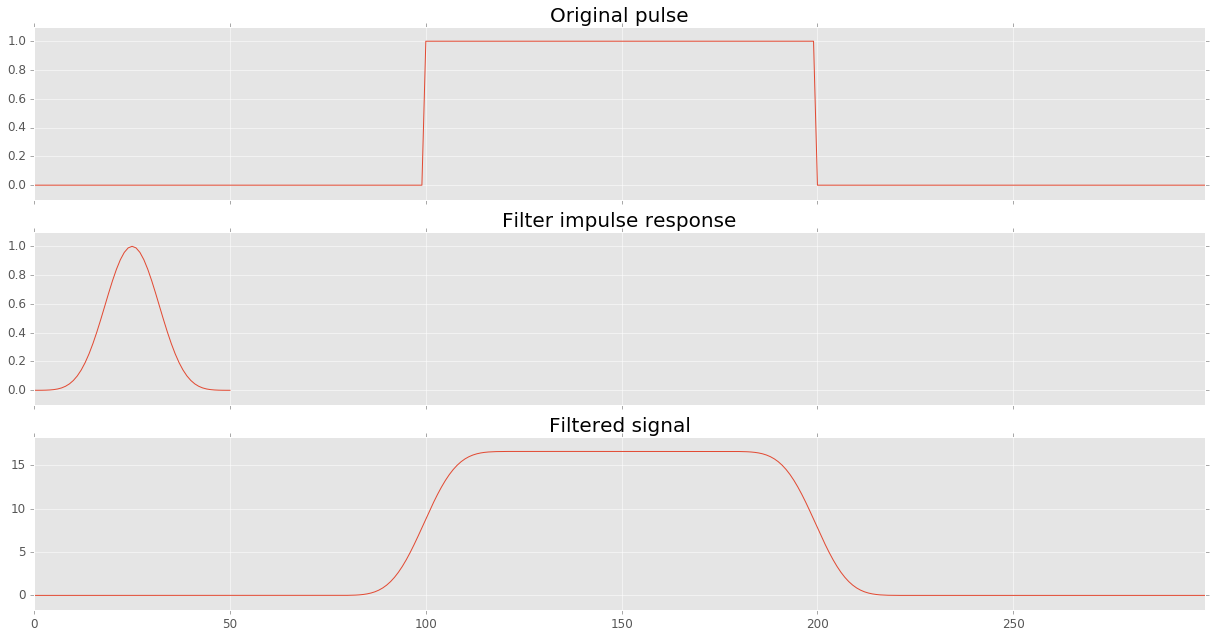

In [233]:
# Cell 3b - change one signal, convolve both signals + plotting

# make a box car function
sig = np.repeat([0., 1., 0.], 100)

# make a kaiser signal "http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.kaiser.html#scipy.signal.kaiser" 
win = signal.kaiser(51, beta=14)

# convolve the signals
filtered = signal.convolve(sig, win, mode='same')

# plot
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()


C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


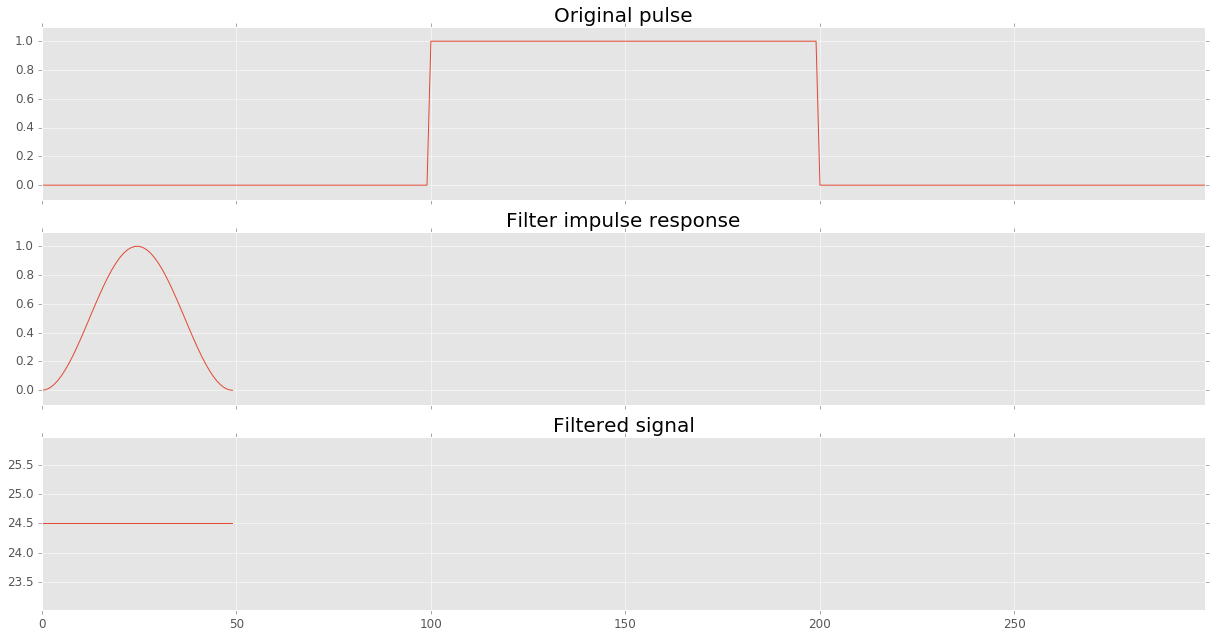

In [200]:
# Cell 3c - convolution in reverse order + plotting

# make a box car function
sig = np.repeat([0., 1., 0.], 100)

# make a Hann window 
win = signal.hann(50)

# convolve the signals in reverse order
filtered = signal.convolve(win, sig, mode='same')

# plot
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


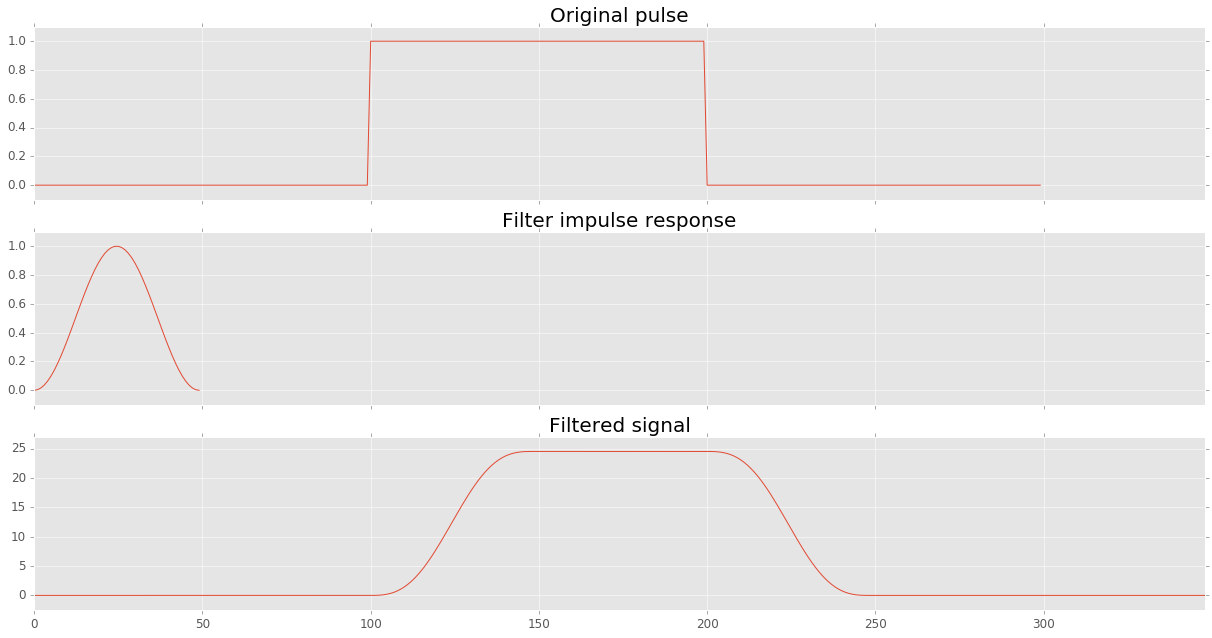

In [224]:
# Cell 3d - amend signals and convolve again (bonus)

# make a box car function
sig = np.repeat([0., 1., 0.], 100)

# make a Hann window 
win = signal.hann(50)

# convolve the signals, change mode 'same' to 'full'
filtered = signal.convolve(win, sig, mode='full')

# plot
fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()


### Answer to exercise 3

a) Convolution is an integral that expresses the amount of overlap of one function g as it is shifted over another function f . Qualitatively It mixes one function with another.“http://mathworld.wolfram.com/Convolution.html”
Convolution is closely connected to linear systems. The output of a linear system is the convolution of the input and the impulse response (the signal produced by a system when the input is a delta function).
Largely used in seismology as the convolution theorem: A convolution in the time domain corresponds to a multiplication in the frequency domain.

Taken from [signal.convolve](http://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html)
Mode : str {‘full’, ‘valid’, ‘same’}, optional. 
A string indicating the size of the output:
1. full: The output is the full discrete linear convolution of the inputs. (Default)
2. valid: The output consists only of those elements that do not rely on the zero-padding.
3. same :The output is the same size as in1, centered with respect to the ‘full’ output.

b) Our convolution is commutative due to involving the condition that a group of quantities connected by operators gives the same result whatever the order of the quantities involved. i.e. giving a "full" mode (The output is the full discrete linear convolution of the inputs) gives commutativity of convolution and we will get the same result as in cell 3a.

c) The results of 3c is different from cell 3a, we can observe inconsistency between the result from cell 3a and 3c. This is obvious due to we convolve in reverse order. We convolve win with sig which resulting signal with same length with win centered with respect to win. While in cell 3a we convolve sig with win which resulting signal with same length with sig centered with respect to sig.

d) We try to amend the signals so that convolving them in the reverse order and we have the same result as convolving them in original order. in Cell 3c, we change the mode 'same' to mode='full', this will caused the convolution to be the same as in cell 3a, but we observe offset on the right of the result.


__________________

## Exercise 4


In Cell 4a theoretical gravity data, modeled for the ringlaser location in Wettzell, are loaded. The data show a superposition of tidal effects due to different celestial bodies. Here is a short overview of the most important ones, sorted according the amplitude of their influence on Earth:
+ tides with a period of half a day from sun, moon, Mars, Jupiter, etc. ..., period: 0.5 day 
+ tides with a period of one day from sun, moon, Mars, Jupiter, etc. ..., period: 1 days
+ cycle of the orbit of the moon, period: 28 days
+ equinox - sun and moon passing the equator plane, period: 186 days (about every six months)
+ Chandler wobble (deviation of Earth's axis of rotation relative to the solid Earth), period: 433 days
+ effects due to further planets ....


a) In Cell 4b, calculate the spectrum of the data and plot it (as a log-log plot). Try to identify the different tidal effects and name the frequencies of their peak positions. Why is the peak for the Chandler wobble not really visible in the spectrogram? 
Hint: To calculate the spectrum, you can use the function [periodogram](http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.signal.periodogram.html) of the scipy.signal package.

b) In Cell 4c, try to separate the tides with periods of half and full day from the other tidal effects by filtering. Which filter do you choose and why? Plot the filtered signal for about the first 28 days.  
Explain what happens behind the screens when applying a filter to data (in mathematical sense). 

c) Now, isolate the half day and full day tides separately from each other and from the rest of the data. Which filter do you choose this time and why? Plot the filtered signal for about the first 25 days on top of the filtered data from exercise 1b.  
How can a filter be defined, in terms of responses? There are mainly three different keywords. Describe them. Why do we need three instead of only one definition?


1 Trace(s) in Stream:
XX.WETZ..XZ | 2015-01-01T00:00:00.000000Z - 2015-12-30T23:00:00.000000Z | 3600.0 s, 8736 samples
         network: XX
         station: WETZ
        location: 
         channel: XZ
       starttime: 2015-01-01T00:00:00.000000Z
         endtime: 2015-12-30T23:00:00.000000Z
   sampling_rate: 0.0002777777777777778
           delta: 3600.0
            npts: 8736
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'encoding': 'FLOAT32', 'filesize': 36864, 'number_of_records': 9, 'dataquality': 'D', 'byteorder': '>', 'record_length': 4096})


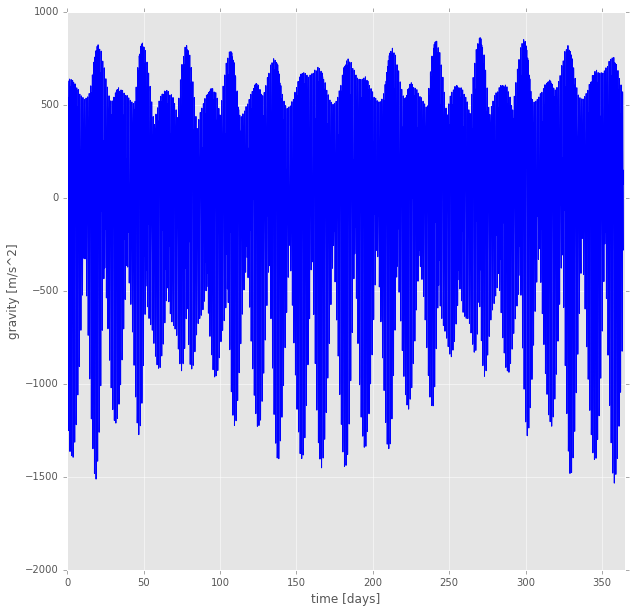

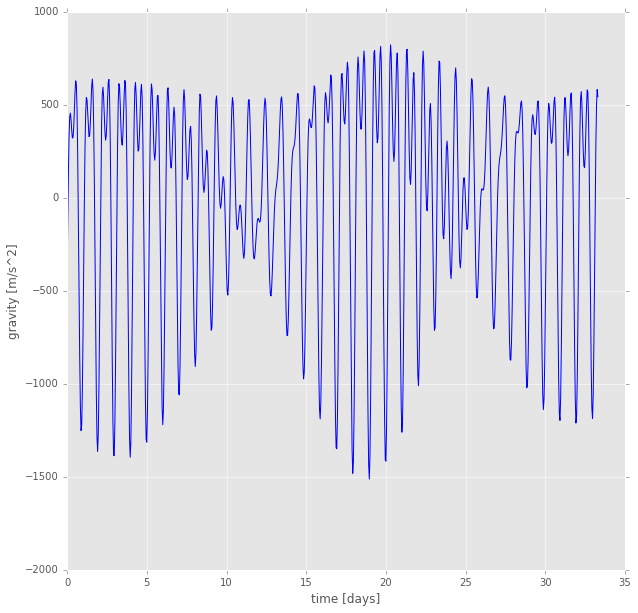

In [18]:
# Cell 4a - reading and plotting gravity data

# read in gravity data, modeled for Wettzell, Germany. Units is in nm/s^2 vertical acceleration. 
filename = 'data/gravity.dat'

# prepare to input data into obspy Stream
data = np.loadtxt(filename, dtype='float32', comments="#")
stats = {'network': 'XX', 'station': 'WETZ', 'location': '',
         'channel': 'XZ', 'npts': len(data), 'delta': 3600}

stats['starttime'] = UTCDateTime("2015,01,01,00,00,00")
s = Stream([Trace(data=data, header=stats)])

# write as MSEED file
s.write("gravity.mseed", format='MSEED')

# test that it worked, read stream from file and plot
st = read("gravity.mseed")
print(st)
print(st[0].stats)
#st.plot()

plt.plot(st[0].times()/(3600*24), st[0].data, color='b')
plt.xlim(0,365)
plt.xlabel("time [days]")
plt.ylabel("gravity [m/s^2]")
plt.show()

# zoom into first 35 days
plt.plot(st[0].times()[0:800]/(3600*24), st[0].data[0:800], color='b')
plt.xlabel("time [days]")
plt.ylabel("gravity [m/s^2]")
plt.show()

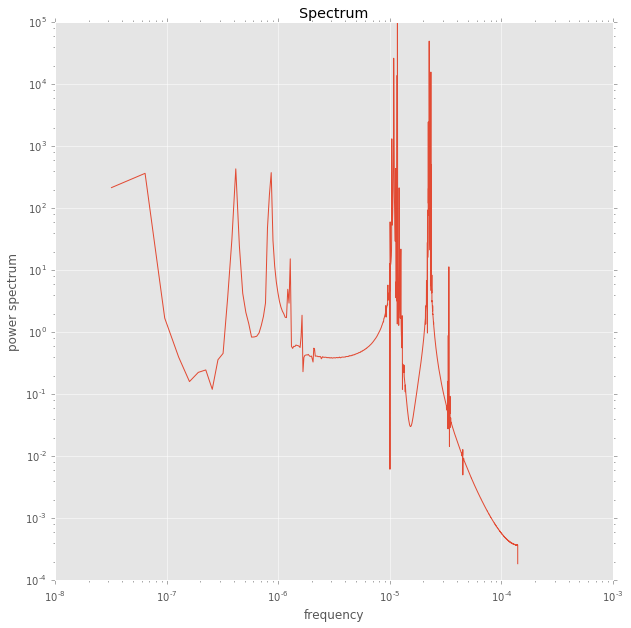

In [19]:
# Cell 4b - calculate spectrum

# Sampling frequency 1 sample per hour (60*60s=3600s)
fs = 0.00028

# freq: Array of sample frequencies 
# pow_spec: Power spectrum of st[0] or time series of measured values
freq, pow_spec = signal.periodogram(st[0],fs, scaling='spectrum') 

# Plot the data spectrum:
plt.loglog(freq, pow_spec)
plt.xlabel('frequency')
plt.ylabel('power spectrum')
plt.ylim((0.0001,100000))
plt.title('Spectrum')
plt.show()

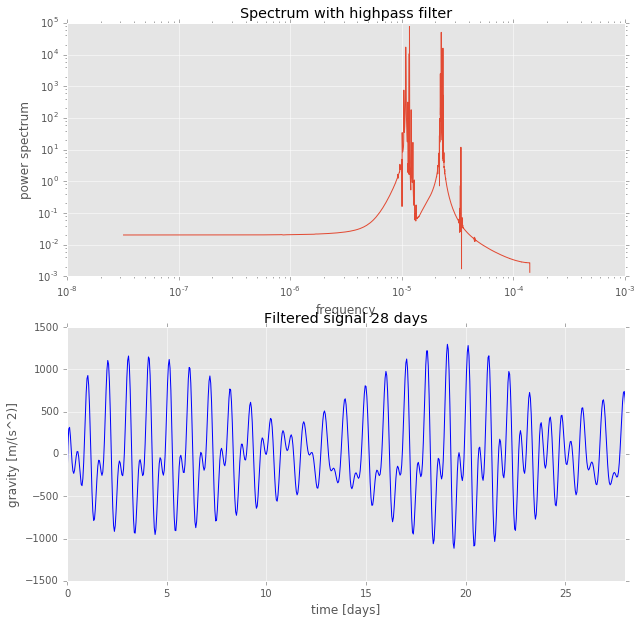

In [20]:
# Cell 4c - filtering the data

from obspy.signal.filter import highpass

# apply highpass filter
st_filt = st.copy().filter("highpass", freq = 0.00001)
freq2, pow_spec2 = signal.periodogram(st_filt[0],fs, scaling='spectrum')

# Plot filtered spectrum
plt.subplot(211)
plt.loglog(freq2, pow_spec2)
plt.xlabel('frequency')
plt.ylabel('power spectrum')
plt.ylim((0.001,100000))
plt.title('Spectrum with highpass filter')

# Plot filtered signal for the first 28 days
plt.subplot(212)
plt.plot(st_filt[0].times()/(3600*24), st_filt[0].data, color='b')
plt.xlim(0,28)
plt.title('Filtered signal 28 days')
plt.xlabel('time [days]')
plt.ylabel('gravity [m/(s^2)]')
plt.show()

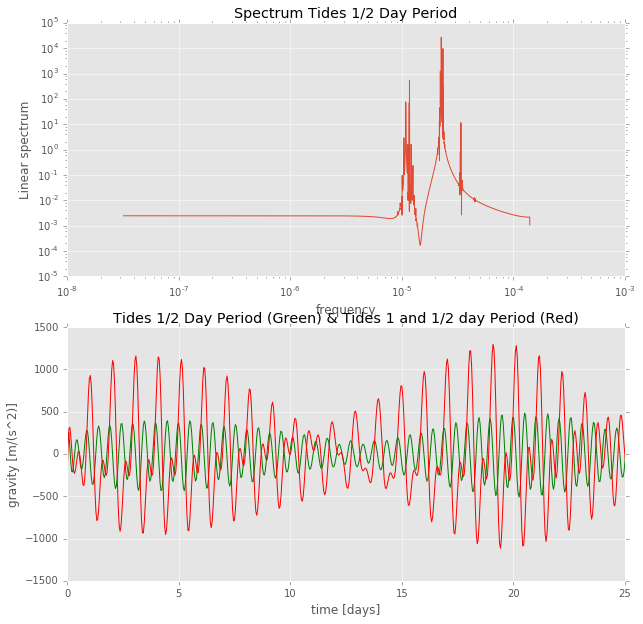

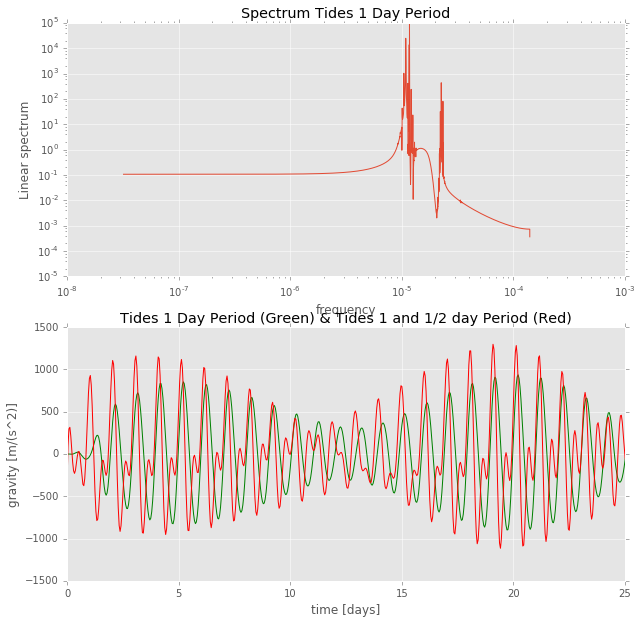

In [21]:
# Cell 4d - filtering tides with periods of half day and full day 

from obspy.signal.filter import highpass

# apply highpass filter at 2.2x10^-5 Hz
st_filt = st.copy().filter("highpass", freq = 0.000022)

freq2, pow_spec2 = signal.periodogram(st_filt[0],fs, scaling='spectrum')

# plot Spectrum Tides 1/2 Day Period
plt.subplot(211)
plt.loglog(freq2, pow_spec2)
plt.xlabel('frequency')
plt.ylabel('Linear spectrum')
plt.ylim((0.00001,100000))
plt.title('Spectrum Tides 1/2 Day Period')

# plot Tides 1/2 Day Period (Green) & Tides 1 and 1/2 day Period (Red)
plt.subplot(212)
plt.plot(st_filt[0].times()/(3600*24), st_filt[0].data, color='g', label='period of 1/2 day')
plt.xlim(0,25)
plt.title('Tides 1/2 Day Period (Green) & Tides 1 and 1/2 day Period (Red)')
plt.xlabel('time [days]')
plt.ylabel('gravity [m/(s^2)]')

# apply highpass filter at 10^-5 Hz
st_filt = st.copy().filter("highpass", freq = 0.00001)
freq2, pow_spec2 = signal.periodogram(st_filt[0],fs, scaling='spectrum')

# plot Tides 1/2 Day Period (Green) & Tides 1 and 1/2 day Period (Red)
plt.subplot(212)
plt.plot(st_filt[0].times()/(3600*24), st_filt[0].data, color='r', label='both signals')
plt.xlim(0,25)
plt.title('Tides 1/2 Day Period (Green) & Tides 1 and 1/2 day Period (Red)')
plt.xlabel('time [days]')
plt.ylabel('gravity [m/(s^2)]')
plt.show()

# apply bandpass filter between 10^-5 Hz and 1.8x10^-5 Hz
st_filt = st.copy().filter("bandpass", freqmin = 0.00001, freqmax = 0.000018)
freq2, pow_spec2 = signal.periodogram(st_filt[0],fs, scaling='spectrum')

# plot Spectrum Tides 1 Day Period
plt.subplot(211)
plt.loglog(freq2, pow_spec2)
plt.xlabel('frequency')
plt.ylabel('Linear spectrum')
plt.ylim((0.00001,100000))
plt.title('Spectrum Tides 1 Day Period')

# plot Tides 1 Day Period (Green) & Tides 1 and 1/2 day Period (Red)
plt.subplot(212)
plt.plot(st_filt[0].times()/(3600*24), st_filt[0].data, color='g', label='period of 1 day')
plt.xlim(0,25)
plt.title('Tides 1 Day Period (Green) & Tides 1 and 1/2 day Period (Red)')
plt.xlabel('time [days]')
plt.ylabel('gravity [m/(s^2)]')

# apply the highpass filter at 10^-5 Hz
st_filt = st.copy().filter("highpass", freq = 0.00001)
freq2, pow_spec2 = signal.periodogram(st_filt[0],fs, scaling='spectrum')

# plot Tides 1 Day Period (Green) & Tides 1 and 1/2 day Period (Red)
plt.subplot(212)
plt.plot(st_filt[0].times()/(3600*24), st_filt[0].data, color='r', label='both signals')
plt.xlim(0,25)
plt.title('Tides 1 Day Period (Green) & Tides 1 and 1/2 day Period (Red)')
plt.xlabel('time [days]')
plt.ylabel('gravity [m/(s^2)]')
plt.show()

### Answer to exercise 4

a) The data show a superposition of tidal effects due to different celestial bodies.
- tides with a period of half a day from sun, moon, Mars, Jupiter, etc. ..., they will have a frequency of around 2.3x10^-5 Hz and peaks are between 2x10^-5 and 4x10^-5 Hz
- tides with a period of one day from sun, moon, Mars, Jupiter, etc. ..., they will have a frequency of around 1.2x10^-5 Hz and peaks are between 10^-5 and 1.5x10^-5 Hz
- cycle of the orbit of the moon on period of 28 days, they will have a frequency of around 4.1x10^-7 Hz and peaks are between 3x10^-7 and 9x10^-7 Hz
- equinox - sun and moon passing the equator plane on period of 186 days, they will have a frequency of around 6.2x10^-8 Hz and  peaks are between 5x10^-8 and 7x10^-8 Hz
- Chandler wobble is deviation of Earth's axis of rotation relative to the solid Earth and has period of 433 days, they will have a frequency of around 2.7x10^-8 Hz. Chandler wobble not really visible in the spectrogram. because the chandler wobble happens every 433 days which is higher than the period of our data 1 year or 365 days, thus we can not identify it in our spectrum, it is smaller than the range of the our spectrum.

b) High pass filter is chosen because we want to keep the frequencies of half and full day tides to be the highest among the tidal effects.  Our high pass filter would remove all low frequency information, we only keep the higher frequencies in the filtered signal. Since our interest is in the half and full day tides, which were the highest frequency components compared to the other signals.
In mathematical point of view, applying a filter means we convolve our data with chosen filter, i.e. high pass filter (10^-5 Hz), this means in the frequency domain all of data with frequency values above it will multiplied by 1, and frequency below it will multiplied by 0. Note that there will be transition at the corner of our filter.

c) we choose bandpass filter to isolate half day and full day tides separately from each other and we not interested to the rest of data. By looking the frequency response of our tides, we can design bandpass filter in the range of our interest peak frequency response.
For the half day tides the chosen filter is a high pass filter at 2.2x10^-5 since the frequency of the half day tides is about 2.3x10^-5. and for the full day tides the chosen filter is a band pass filter between 2.2x10^-5 since the frequency of the half day tides is about 2.3x10^-5.

There are 3 keywords, they are:
- The frequency response is our filter in the frequency domain.
- The fourier transform is the operation to go from the time to the frequency domain.
- The impulse response is our filter in the time domain.

A filter is defined as the frequency response function which is the Fourier transform of the impulse response function, defined as the response of a filter to an impulsive input signal i.e. delta function.

___________________

## Exercise 5

In this question we are going to use a cross correlation technique to make a differential pick time. You are provided with two signals in the data directory: 

`data/seismogram_1.MSEED` <br>
`data/seismogram_2.MSEED`

seismogram_2.MSEED is noisy, and arrives later than seismogram_1.MSEED. We will use a cross-correlation with the better seismogram to make a more accurate pick of the arrival time on the noisy seismogram. 

For this question you should use the obspy function xcorr_pick_correction(). This is well documentated, and has good default plotting options. 

You are given these initial pick times. <br>
t1 = UTCDateTime(0.335)<br>
t2 = UTCDateTime(0.55)

a) Read in the seismograms in Cell 5a. Use the function [xcorr_pick_correction](https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.xcorr_pick_correction.html) to create a cross correlation. There is no need to filter the seismograms.  <br>
Plot the cross correlation. Display the Time correlation and Correlation coefficient.

b) What was the length of the time window you cross-correlated over? Why is this a good choice?  

c) Calculate the corrected differential pick time in Cell 5b. This is the time lag between the first arrival on seismogram 1 and on seismogram 2.

d) Write a short paragraph on what has been done here, and why it could be useful. 


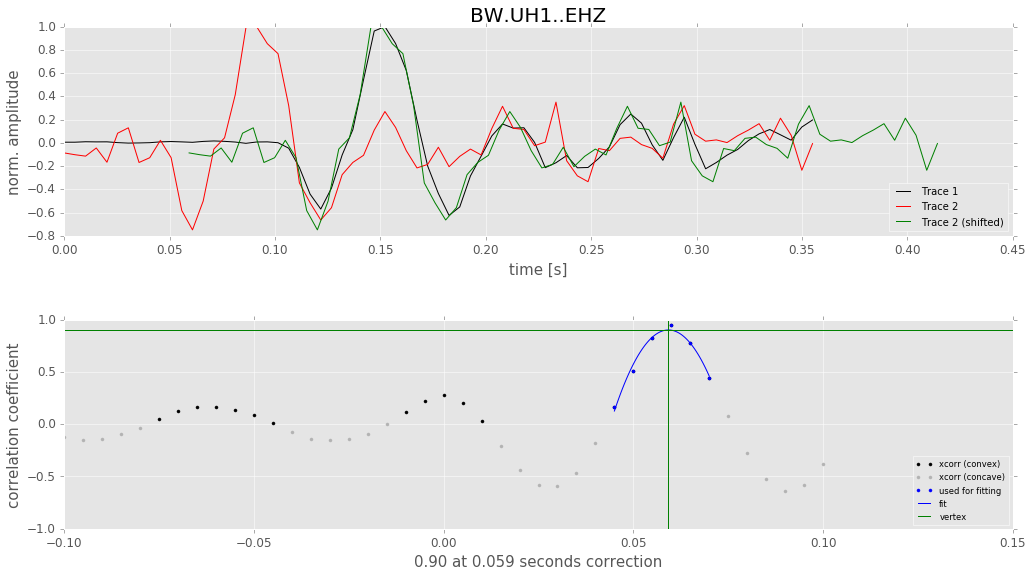

No preprocessing:
  Time correction for pick 2: -0.059247
  Correlation coefficient: 0.90
1 Trace(s) in Stream:
BW.UH1..EHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.845000Z | 200.0 Hz, 170 samples 
 1 Trace(s) in Stream:
BW.UH1..EHZ | 1970-01-01T00:00:00.000000Z - 1970-01-01T00:00:00.845000Z | 200.0 Hz, 170 samples


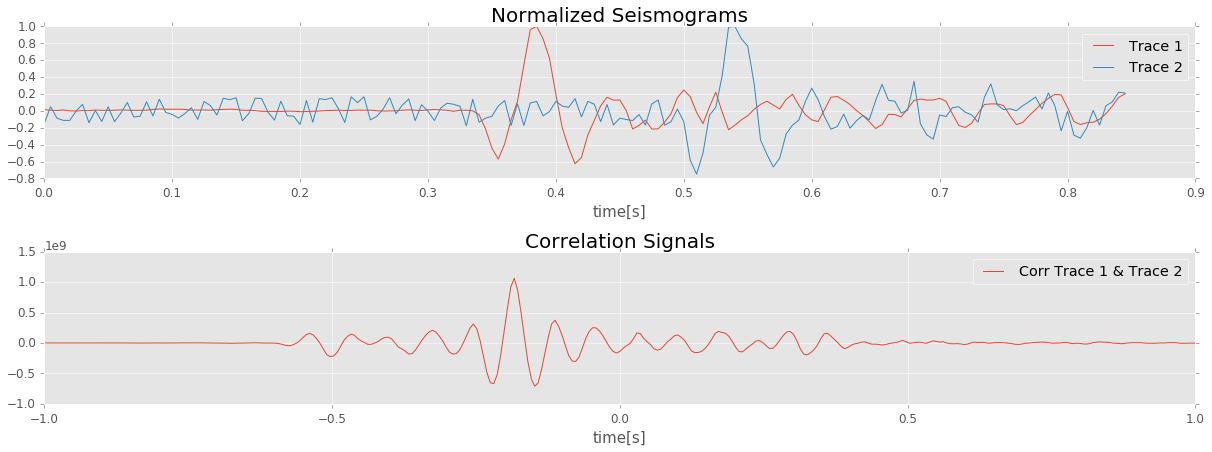

Lag trace 1 and trace 2: -0.183432 seconds
Correlation coefficient trace 1 and trace 2: -0.113265 



In [212]:
# Cell 5a - crosscorrelation

# code modified from "https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.xcorr_pick_correction.html"

from __future__ import print_function
import obspy
from obspy.signal.cross_correlation import xcorr_pick_correction

st1 = obspy.read('data/seismogram_1.MSEED')
st2 = obspy.read('data/seismogram_2.MSEED')
# select the single traces to use in correlation.
# to avoid artifacts from preprocessing there should be some data left and
# right of the short time window actually used in the correlation.
tr1 = st1.select(component="Z")[0]
tr2 = st2.select(component="Z")[0]
# these are the original pick times set during routine analysis
t1 = obspy.UTCDateTime(0.335) # pick 1
t2 = obspy.UTCDateTime(0.55)  # pick 2

# estimate the time correction for pick 2 without any preprocessing and open
# a plot window to visually validate the results
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, 0.05, 0.2, 0.1, plot=True)
print("No preprocessing:")
print("  Time correction for pick 2: %.6f" % dt)
print("  Correlation coefficient: %.2f" % coeff)

# print the correlation function
print(st1, '\n', st2)

xcorr1 = np.correlate(tr1.data, tr2.data, mode='full')
peak_index1 = abs(xcorr1).argmax()
cc1 = np.corrcoef(tr1.data, tr2.data)[0,1]

cc_t = np.linspace(-1.0, 1.0, len(xcorr1))

plt.subplot(3,1,1)
plt.title('Normalized seismograms')
plt.plot(tr1.times(), tr1.data/abs(tr1.max()), label='Trace 1')
plt.plot(tr2.times(), tr2.data/abs(tr2.max()), label='Trace 2')
plt.legend()

plt.xlabel('time[s]')

plt.subplot(3,1,2)
plt.title('Correlation signals')
plt.plot(cc_t, xcorr1, label='Corr Trace 1 & Trace 2')

plt.legend()
plt.xlabel('time[s]')

plt.tight_layout() 
plt.show()

print("Lag trace 1 and trace 2: %f seconds" % cc_t[peak_index1])
print("Correlation coefficient trace 1 and trace 2: %f \n" % cc1)


c:\anaconda3\lib\site-packages\obspy-1.0.1-py3.5-win-amd64.egg\obspy\signal\cross_correlation.py:317: UserWarning: Artifacts from signal processing possible. Trace 0 should have more additional data at the start.
  warnings.warn(msg)
c:\anaconda3\lib\site-packages\obspy-1.0.1-py3.5-win-amd64.egg\obspy\signal\cross_correlation.py:321: UserWarning: Artifacts from signal processing possible. Trace 0 should have more additional data at the end.
  warnings.warn(msg)
c:\anaconda3\lib\site-packages\obspy-1.0.1-py3.5-win-amd64.egg\obspy\signal\cross_correlation.py:321: UserWarning: Artifacts from signal processing possible. Trace 1 should have more additional data at the end.
  warnings.warn(msg)


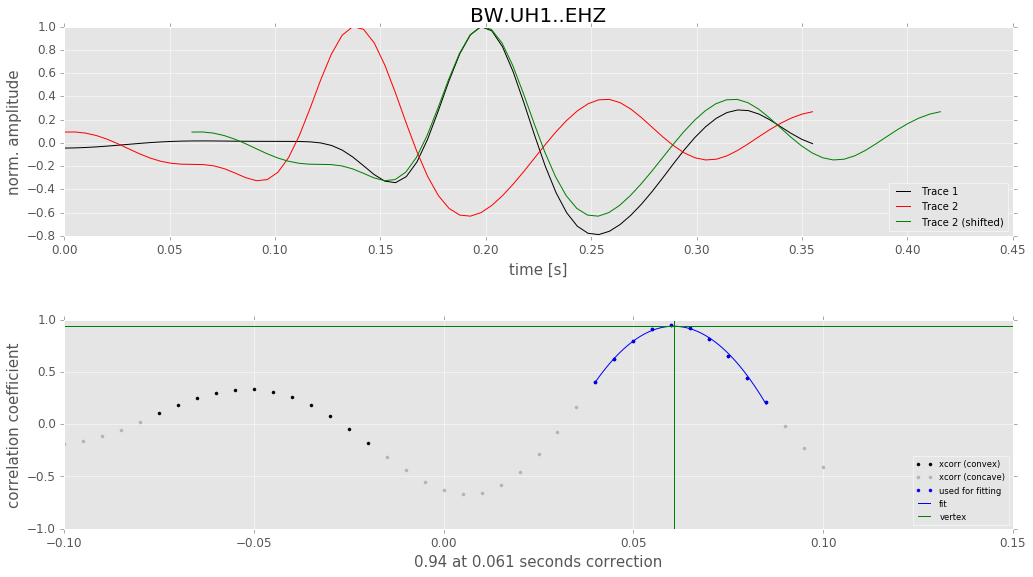

Bandpass prefiltering:
  Time correction for pick 2: -0.060608
  Correlation coefficient: 0.94


In [209]:
# Cell 5b - differential pick times
# code modified from "https://docs.obspy.org/packages/autogen/obspy.signal.cross_correlation.xcorr_pick_correction.html"
# apply bandpass
dt, coeff = xcorr_pick_correction(t1, tr1, t2, tr2, 0.05, 0.2, 0.1, plot=True,
                                  filter="bandpass",
                                  filter_options={'freqmin': 1, 'freqmax': 10})
print("Bandpass prefiltering:")
print("  Time correction for pick 2: %.6f" % dt)
print("  Correlation coefficient: %.2f" % coeff)

### Answer to exercise 5

b) The length of the time window we cross-correlated over our data 0-0.45 s.
Components used in our cross-corelation:
t_before=0.05, t_after=0.2, cc_maxlag=0.10, 
- t_before (float):
Time to start cross correlation window before pick times in seconds.
- t_after (float):
Time to end cross correlation window after pick times in seconds.
- cc_maxlag (float):
Maximum lag/shift time tested during cross correlation in seconds.

Thus the time window length used in cross-correlated 1 is (0.335+0.2)-(0.335-0.05)=0.200 s
Thus the time window length used in cross-correlated 2 is (0.55+0.2)-(0.55-0.05)=0.200 s

This is a good choice because distance and magnitude is within our time window range, we keep it narrow because we do not want other signal affected our coefficient. On the graph above we have very good correlation coefficient = 0.94.

c) Using cell 5b, the difference in pick times calculation by considering the time lag between two maxima event. Roughly, the calculation of those time lag is about 0.06 seconds.

d) In this exercise, we try to do cross-correlation between 2 traces of signal from 2 different stations. We want to determine the similarity between two traces of signal by filtering it. As we seen on the second picture above, we observe that both of the traces are quite similar. It is useful to consider noise since we do not have to wait for an earthquake source to occur to gather data. i.e. seismic interferometry method using such coherent noise.


________________

## Final bonus question

Between sound, tidal, and seismic/seismological data, what do you prefer to work on considering computational effort? Explain why.

### Answer to bonus question

Considering computational effort, work with tidal data compared with seismic data and sound data is more preferable, this is the challenge of the high frequencies data. Higher frequency means heavier their computational costs. 
For example, considering sound data, the maximum frequency for human ear has a frequency of around 2x10^4 Hz which means the Nyquist frequency is around 4x10^4 Hz. 
For Tidal data, the maximum frequency is around 2x10^-5 Hz which means the Nyquist frequency is around 4x10^-5 Hz.
And also for seismic/seismological data, the maximum frequency contained is around 10^2 Hz i.e. in reflection seismology, which means the Nyquist frequency would be around 2x10^2 Hz, or 10^-2 to 10^0 Hz for global seismology.
In conclusion, the higher the nyquist frequency the higher the computational costs. Tidal data has the lowest Nyquist frequency meaning it has the lowest computational costs followed by seismic/seismological data while sound data has the highest computational effort.